In [1]:
!pip install git+https://github.com/jsh9/python-plot-utilities

# Functions and imports

In [7]:
# Imports
from brian2 import *
import sympy
import plot_utils
from PIL import Image
import os, os.path
import numpy as np
import skimage

import matplotlib.pyplot as plt

#scikit-image ???
from skimage.measure import compare_ssim
from skimage.color import rgb2gray
from skimage.io import imread

print("Imports done")

#################################################

'''
diff_to_pos(gray1,gray2,th): movement
gray1, gray2: images compared (SSIM algo)
th: is the theshold of maximal likelihood (result of SSIM algo) between 0 and 1

return: probable movement position (mean) and variance of this estimation
'''

def diff_to_pos(gray1,gray2,th,fct="mean"):

    # compute ssim (struc sim)
    (score, sim) = compare_ssim(gray1, gray2, full=True)
    sim[sim>th] = 1 #discard little changes, if sim = 1 not diff between grp of pixels, if sim = 0 totally diff

    # reduce to 1D (column)
    col_mean = np.array(1 - sim).sum(0) # 1 - values to inverse and compute according to max of diff

    if col_mean.sum() == 0:
        return {"m": None,"v": None}

    else:
        if fct == "mean":
            col_mean /= max(col_mean)
            values = np.array([col_mean[i]*i for i in range(len(col_mean))])
            mean = values.sum() / col_mean.sum()

            values = np.array([abs(i-mean)*col_mean[i] for i in range(len(col_mean))])
            var = values.sum() / col_mean.sum()

        return {"m": round(mean,0),"v": var}

#################################################

'''
pos_to_move(pos1,pos2,th,width): movement
th: minimal movement (% of width) as positions and width are in pixel
return: -1 goes to the left, 1 to the right, 0 not enough changes (based on 2 consecutive movement positions: pos1 and pos2)
'''

def pos_to_move(pos1,pos2,th,width):
    ret = 0
    if (abs(pos1-pos2)/width > th):
        if (pos1 < pos2):
            ret = 1
        else:
            ret = -1
    return ret

#################################################

'''
vid_to_movement(frames,move_th,sim_th): movements
frames: is a list of grayscaled frame (at least 3 images)
move_th: is a coefficient for the threshold dection of a minimal movement (if no movement, keep first position in memory)
sim_th: is a threshold for a maximal likelihood between pictures

return: {"moves": list_of_movements, "positions": {"m": mean, "v" variance}}

WARNING: at least 3 frames should be necessary to compute 2 frame diff and get one "movement"
    Thus for N pictures, it return N-2 "movement"
'''

def video_processing(frames,move_th,sim_th):

    if len(frames) > 3:
        frame_arr = np.array(frames)
        img_width = len(frames[0][0])
        
        pos_list = []
        for i in range(len(frames)-1):
            pos_list.append(diff_to_pos(frame_arr[i],frame_arr[i+1],sim_th))
        
        mv_list = []
        prev_pos = pos_list[0]['m']

        #get first pos
        static_i = 1
        while prev_pos == None and static_i < len(pos_list) - 1:
            prev_pos = pos_list[static_i]['m']
            mv_list.append(0)
            static_i += 1

        #compute "movement"
        for j in range(static_i, len(pos_list)):
            move = 0

            if (pos_list[j]['m'] != None):
                move = pos_to_move(prev_pos,pos_list[j]['m'],move_th,img_width)
                
                if (move != 0):
                    prev_pos = pos_list[j]['m'] #keep in memory new pos if enough "movement" between lastest images
            
            mv_list.append(move)
        
        return {"moves": mv_list, "positions": pos_list}

    else:
        return None
        
#################################################

print("OK")

Imports done
OK


# Record video from Webcam

Execute cell and press "q" to stop video streaming and recording.

In [11]:
import cv2
import pathlib

path = pathlib.Path().absolute().parent.parent
video_path = str(path) #where the video is saved
video_name = "/recorded.mp4"
grayscale = True
fps = 24.0

capture = cv2.VideoCapture(0) # find the webcam
w = capture.get(cv2.CAP_PROP_FRAME_WIDTH)
h = capture.get(cv2.CAP_PROP_FRAME_HEIGHT)
fourcc = cv2.VideoWriter_fourcc(*'mp4v') #record as mp4 format

if grayscale:
    video_writer = cv2.VideoWriter(video_path + video_name,fourcc, fps, (int(w),int(h)), 0)
else:
    video_writer = cv2.VideoWriter(video_path + video_name,fourcc, fps, (int(w),int(h)))

# record video
while (True):
    ret, frame = capture.read()
    if ret:
        if grayscale: frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert to grayscale
        video_writer.write(frame)
        cv2.imshow('Video Stream', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

capture.release()
video_writer.release()
cv2.destroyAllWindows()

# Recorded video

### Extract a list of frame from video file or several pictures

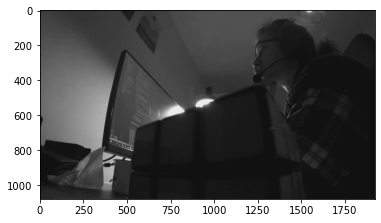

86 frames
 1920.0 x 1080.0 
FPS: 24.0
Settings saved


In [12]:
# Settings

video_format = True     #video should be mp4 format
# video_format = False    #pictures must be grayscaled

path = pathlib.Path().absolute().parent.parent


path= str(path)

frames = []

if video_format: #case we use video file

    import cv2



    video_name = "/recorded.mp4"
    full_path = path + video_name


    vidcap = cv2.VideoCapture(path + video_name) # open video

    # convert to list of frames
    success,image = vidcap.read()
    nbr_frame = 0
    while success:
        frames.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
        success,image = vidcap.read()
        nbr_frame += 1

    if nbr_frame == 0:
        print("Cannot read video")
        print("To get it to work. Put your file in this foler:")
        print(path)
        print("Name it \"test.mp4\"")
    else:
        framerate = vidcap.get(cv2.CAP_PROP_FPS)
        f_width = vidcap.get(cv2.CAP_PROP_FRAME_WIDTH)
        f_high = vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT)

        plt.imshow(frames[0], cmap='gray', vmin=0, vmax=255)
        plt.show()

        print(nbr_frame,"frames\n",f_width,"x",f_high,"\nFPS:",framerate)

else: #case we use multiple picture files
    path = "C:/Users/Benjamin/Documents/LTU/Neural Net. and Learn. Machines/101 - Retina Project/peipa/" #already PGM format for first video
    img_name = "hand-"
    img_format = ".pgm"
    full_path = path + img_name

    framerate = 24 #manual set(FPS)

    nbr_frame = len([name for name in os.listdir(path)]) #in case it's not a video file

    # Simulate video
    for i in range(nbr_frame-1):
        # WARNING should be greyscaled pictures
        #to grayscale : (may be diff between gray cv2 format and gray scikit format)
            #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)       #opencv
            #img_gray = rgb2gray(img)                               #scikit

        frames.append(imread(path + img_name + str(i+1) + img_format))

    f_width = len(frames[0][0])
    f_high = len(frames[0])

    plt.imshow(frames[0], cmap='gray', vmin=0, vmax=255)
    plt.show()

    print(nbr_frame,"frames\n",f_width,"x",f_high,"\nFPS:",framerate)

print("Settings saved")


In [13]:
# processing on pictures included in the list "frames"

move_th = 0.001     # % of total width of the image (below this no mvt is detected)
sim_th = 0.4        #above this threshold, no changes are detected

results = video_processing(frames,move_th,sim_th)
list_pos = [r["m"] for r in results["positions"]]

time_video = []
dt = 1/framerate
for f in range(len(list_pos)):
    time_video.append(round(f*dt,3))

print(list_pos,"\n",time)

[1178.0, None, 1250.0, None, 1237.0, None, 1101.0, None, 898.0, None, 1222.0, None, 1233.0, None, 1313.0, None, 1258.0, None, 1288.0, None, 1281.0, None, 1298.0, None, 1409.0, None, 1327.0, None, 1399.0, None, 1145.0, None, 1229.0, None, 1328.0, None, 1194.0, None, 1126.0, None, 1192.0, None, 1205.0, None, 1159.0, None, 1011.0, None, 886.0, None, 1345.0, None, 1312.0, None, 1353.0, None, 1365.0, None, 1367.0, None, 1365.0, None, 1281.0, None, 1294.0, None, 1275.0, None, 1276.0, None, 1290.0, None, 1293.0, None, 1272.0, None, 1260.0, None, 1326.0, None, 1292.0, None, 1269.0, None, 1280.0] 
 <module 'time' (built-in)>


## Rescale the picure data and removes None values

In [16]:
print(list_pos,"\n",time)
spikes = []
time_for_spikes = []
input_neurons = 40 ### insert no of input neurons here ###
rescale = f_width/(input_neurons-1)

for i,n in enumerate(list_pos):
    if (n != None):
        spikes.append(int(np.round(n/(rescale))))
        time_for_spikes.append(time_video[i])

time = (len(time_for_spikes))

print(spikes)
print(time_for_spikes)



#labels = data_without_zeros['labels']
# = data_without_zeros['spikes']
# = data_without_zeros['times']*ms



[1178.0, None, 1250.0, None, 1237.0, None, 1101.0, None, 898.0, None, 1222.0, None, 1233.0, None, 1313.0, None, 1258.0, None, 1288.0, None, 1281.0, None, 1298.0, None, 1409.0, None, 1327.0, None, 1399.0, None, 1145.0, None, 1229.0, None, 1328.0, None, 1194.0, None, 1126.0, None, 1192.0, None, 1205.0, None, 1159.0, None, 1011.0, None, 886.0, None, 1345.0, None, 1312.0, None, 1353.0, None, 1365.0, None, 1367.0, None, 1365.0, None, 1281.0, None, 1294.0, None, 1275.0, None, 1276.0, None, 1290.0, None, 1293.0, None, 1272.0, None, 1260.0, None, 1326.0, None, 1292.0, None, 1269.0, None, 1280.0] 
 43
[24, 25, 25, 22, 18, 25, 25, 27, 26, 26, 26, 26, 29, 27, 28, 23, 25, 27, 24, 23, 24, 24, 24, 21, 18, 27, 27, 27, 28, 28, 28, 26, 26, 26, 26, 26, 26, 26, 26, 27, 26, 26, 26]
[0.0, 0.083, 0.167, 0.25, 0.333, 0.417, 0.5, 0.583, 0.667, 0.75, 0.833, 0.917, 1.0, 1.083, 1.167, 1.25, 1.333, 1.417, 1.5, 1.583, 1.667, 1.75, 1.833, 1.917, 2.0, 2.083, 2.167, 2.25, 2.333, 2.417, 2.5, 2.583, 2.667, 2.75, 2.833,

## Creates the network

In [17]:
#https://brian2.readthedocs.io/en/stable/examples/frompapers.Stimberg_et_al_2018.example_1_COBA.html
start_scope()

seed(11922)  # to get identical figures for repeated runs


################################################################################
# Model parameters
################################################################################
### General parameters



duration = time_for_spikes[-1]*ms    # Total simulation time
sim_dt = 0.01*ms        # Integrator/sampling step


### Neuron parameters
tau_m = 30*ms         # Excitatory synaptic time constant
V_th = 50e-3         # Firing threshold
V_r = 35e-3          # Reset potential       
R = 90e6




### Synapse parameters
we = 1          # Excitatory synaptic weight
wi = -1           # Inhibitory synaptic weight

#indices = [3,4,5,6,5,4,3,3,4,5,6,5,4,3] #np.linspace(0, 50, num=2)
#times = [10,11,12,13,14,15,16,30,31,32,33,34,35,36]*ms #np.linspace(10, 90, num=2)*ms




################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### Neurons
neuron_eqs = '''
dv/dt = ((V_r-v)+R*I)/tau_m : 1
I : 1
'''
input_group = NeuronGroup(input_neurons, model=neuron_eqs,threshold='v>V_th', reset='v=V_r', method='euler')

neurons = NeuronGroup(3*input_neurons-2, model=neuron_eqs,threshold='v>V_th', reset='v=V_r', method='euler')

left = NeuronGroup(1, model=neuron_eqs,threshold='v>V_th',reset='v=V_r', method='euler')

right = NeuronGroup(1, model=neuron_eqs,threshold='v>V_th',reset='v=V_r', method='euler')

neurons.I  = 50e-12
neurons.v = input_group.v = left.v = right.v = 'V_r'

input_layer = SpikeGeneratorGroup(input_neurons, spikes, time_for_spikes*ms, dt=sim_dt) # assigs 1/4 of the neurons to the input layer
#input_layer = input_group[:input_neurons]
inh_neurons = neurons[:input_neurons] # assigs 1/4 of the neurons to the inhibitory layer
left_layer  = neurons[1*input_neurons:2*input_neurons-1] # assigs 1/4 -1 of the neurons to the left exitatory layer
right_layer = neurons[2*input_neurons-1:3*input_neurons-2] # assigs 1/4 -1 of the neurons to the right exitatory layer
left_neuron = left[0] # assigns 1 of the neurons to the final left layer
right_neuron= right[0] # assigns 1 of the neurons to the final right layer

### Synapses
exc_syn = Synapses(input_layer, inh_neurons, model = 'w : 1', on_pre = 'v += w') # Connects the input layer to the inhibitory layer
exc_syn_left = Synapses(input_layer, left_layer, model = 'w : 1', on_pre = 'v += w') # Connects the input layer to the left exitatory layer
exc_syn_right = Synapses(input_layer, right_layer, model = 'w :1', on_pre = 'v += w') # Connects the input layer to the right exitatory layer
inh_syn_right = Synapses(inh_neurons, right_layer, model = 'w : 1', on_pre = 'v += w') # Connects the inhibitory layer to the right exitatory layer
inh_syn_left = Synapses(inh_neurons, left_layer, model = 'w : 1', on_pre = 'v += w') # Connects the inhibitory layer to the left exitatory layer
final_left = Synapses(left_layer, left_neuron, model = 'w : 1', on_pre = 'v += w') # Connects the left exitatory layer to the final left neuron
final_right = Synapses(right_layer, right_neuron, model = 'w : 1', on_pre = 'v += w') # Connects the right exitatory layer to the final right neuron

exc_syn.connect(i=[*range(0,input_neurons)],j=[*range(0,input_neurons)])
exc_syn_left.connect(i=[*range(1,input_neurons)],j=[*range(0,input_neurons-1)])
exc_syn_right.connect(i=[*range(0,input_neurons-1)],j=[*range(0,input_neurons-1)])
inh_syn_right.connect(i=[*range(1,input_neurons)],j=[*range(0,input_neurons-1)])
inh_syn_left.connect(i=[*range(0,input_neurons-1)],j=[*range(0,input_neurons-1)])
final_left.connect(i=[*range(0,input_neurons-1)],j=0)
final_right.connect(i=[*range(0,input_neurons-1)],j=0)

exc_syn.w = 60e-3
exc_syn_left.w = 60e-3
exc_syn_right.w = 60e-3
inh_syn_right.w = -100e-3
inh_syn_left.w = -100e-3
final_left.w = 60e-3
final_right.w = 60e-3


#visualise_connectivity(exc_syn)
#visualise_connectivity(exc_syn_left)
#visualise_connectivity(exc_syn_right)
#visualise_connectivity(inh_syn_left)
#visualise_connectivity(inh_syn_right)
#visualise_connectivity(final_left)
#visualise_connectivity(final_right)


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
#exc_mon = SpikeMonitor(input_layer)
#inh_mon = SpikeMonitor(inh_neurons)

### We record some additional data from a single excitatory neuron

left_monitor = StateMonitor(left_neuron, 'v', record=0)
left_event = EventMonitor(left, event='spike', variables='v')
right_monitor = StateMonitor(right_neuron, 'v', record=0)
right_event = EventMonitor(right, event='spike', variables='v')
#L_right = StateMonitor(inh_neurons, 'v', record=0)

print('Halfway there')





Halfway there


## Run the network

In [18]:
run(duration, report='text')

WARNING    "w" is an internal variable of group "synapses_1", but also exists in the run namespace with the value 1920.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "w" is an internal variable of group "synapses_2", but also exists in the run namespace with the value 1920.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "w" is an internal variable of group "synapses_3", but also exists in the run namespace with the value 1920.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "w" is an internal variable of group "synapses_4", but also exists in the run namespace with the value 1920.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "w" is an internal variable of group "synapses_5", but also exists in the run namespace with the value 1920.0. The internal variable 

Starting simulation at t=0. s for a duration of 3.5 ms
3.5 ms (100%) simulated in < 1s


## Evaluate the result

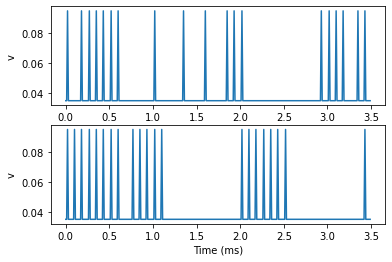

In [19]:
import copy

figure()
subplot(211)
plot(left_monitor.t/ms, left_monitor.v[0])
xlabel('Time (ms)')
ylabel('v');
subplot(212)
plot(right_monitor.t/ms, right_monitor.v[0])
xlabel('Time (ms)')
ylabel('v');

#print(left_event.it[1].__getitem__(0))
#left_array = left_event.it[1].__array__()
#right_array = right_event.it[1].__array__()
#result = network_guess(left_array,right_array)

#final_result = copy.deepcopy(result)
#for i in range(0, len(result)):
#    final_result[i] = (result[i] == labels[i])

#print(final_result)

